In [1]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
from scipy.signal import butter, lfilter
import librosa, librosa.display
from scipy.signal import hilbert, chirp
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import glob
from brian2 import *
from brian2hears import *
%matplotlib inline


def bandpower(data, sf, band, window_sec=None, relative=False):
    from scipy.signal import welch
    import scipy
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = scipy.signal.welch(data, sf,window = 'hamming',nfft = 512 ,scaling = 'density',average = 'mean')
#     if peak:
#         stats = dict(zip(freqs, psd))
#         peak_amp = (max(psd))
#         peak_freq = (max(stats, key=stats.get))
#         return peak_amp, peak_freq
    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)  # assignment operator shorthand for / and =
        
    return freqs, psd ,bp
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butt_low(lowcut, fs, order=5):
    nyq = 0.5 * sr
    low = lowcut / nyq
    b, a = butter(order, low, btype='low')
    return b, a


In [ ]:
## 今日任务 统计一下 时长分布 然后选取是否需要的时长范围； 最后是 单语句选择法 而不是切分。

In [ ]:
#path = [r'D:\Wav_al\RU_test','D:\Wav_al\JP_TEST','D:\Wav_al\VN_TEST','D:\Wav_al\TH_TEST','D:\Wav_al\KR_TEST','D:\Wav_al\CN_TEST']


path = [r'F:\Wav_al\JP','F:\Wav_al\RU','F:/Wav_al/CN_TEST']

for pt in path:
    file_list = glob.glob(pt + r"\*\sent\*.wav")  # glob匹配所有的符合条件的文件，并将以list的形式返回 国家
    result_all = []
    for audio in file_list[0:200]:
        print(audio)
        x, sr = librosa.load(audio)
        x, index = librosa.effects.trim(x,top_db= 20)
        fs = sr
        edges = [10,100,300,700,1750,3900,7250];       
        low = edges[:-1]
        high = edges[1:]

        modulation_filter = [2,4,8,16,32,64];   
        #modulation_filter = [0.1,0.9,2.5,8,12,40];       

        lowcut = modulation_filter[:-1]
        highcut = modulation_filter[1:]
        af_s = []
        env = []
        final = []
        energy_all = []

        for i in range(len(low)): 
            y = butter_bandpass_filter(x, low[i], high[i], fs , order=2)
            amplitude_envelope = np.abs(y)
            b, a = butt_low(30, fs, order=4)
            z = lfilter(b, a, amplitude_envelope)
            env.append(z)  # 包络；
            af_s.append(y)  # 滤波 过后的信号；


        for j in range(len(env)):  
            for i in range(len(lowcut)):
                modu = []
                y= butter_bandpass_filter(env[j], lowcut[i], highcut[i], fs , order=2)
                modu.append((y))
                final = final + modu

        for i in range(len(final)):
            x = final[i]
            hop_length = 256  
            frame_length = 512
            energy = numpy.array([
                sum(abs(x[i:i+frame_length]**2))
                for i in range(0, len(x), hop_length)
            ])
            energy_all.append(energy)

        E = np.array(energy_all)
        E_re = E.reshape(5,6,len(energy))
        E_mean = np.mean(E_re,2)
        result = E_mean.flatten()
        result_all.append(result)
    ss = np.array(result_all)
    f=open('data/result_all_wav_jp_ru_cn.csv','ab')
    np.savetxt(f,ss,delimiter=',')
    f.close()

In [8]:
#path = 'D:\Wav_al\RU_test'
#file_list = glob.glob(path + r"\*\sent\*.wav")  # glob匹配所有的符合条件的文件，并将以list的形式返回 国家
#result_all = []
#for audio in file_list:
#audio = file_list[2]
x, sr = librosa.load('audio/modified/Cn1.wav')
#x, sr = librosa.load(audio)
x, index = librosa.effects.trim(x,top_db= 20)
fs = sr

cf = erbspace(125*Hz, 3.5*kHz, 19)
#gammatone = Gammatone(x, cf)
#edges = [10,100,300,700,1750,3900,7250];       
low = cf[:-1]
high = cf[1:]

modulation_filter = [2,4,8,16,32,64];       
lowcut = modulation_filter[:-1]
highcut = modulation_filter[1:]
af_s = []
env = []
final = []
energy_all = []

for i in range(len(low)): 
    y = butter_bandpass_filter(x, low[i], high[i], fs , order=2)
    amplitude_envelope = np.abs(y)
    b, a = butt_low(30, fs, order=4)
    z = lfilter(b, a, amplitude_envelope)
    env.append(z)  # 包络；
    af_s.append(y)  # 滤波 过后的信号；


for j in range(len(env)):  
    for i in range(len(lowcut)):
        modu = []
        y= butter_bandpass_filter(env[j], lowcut[i], highcut[i], fs , order=2)
        modu.append((y))
        final = final + modu

for i in range(len(final)):
    x = final[i]
    
    hop_length = 1411  
    frame_length = 5600
    energy = numpy.array([
        sum(abs(x[i:i+frame_length]**2))
        for i in range(0, len(x), hop_length)
    ])
    energy_all.append(energy)

E = np.array(energy_all)
E_re = E.reshape(5,18,len(energy))
E_mean = np.mean(E_re,2)
#result = E_mean.flatten()
#result_all.append(result)

#f=open('result.csv','ab')
#np.savetxt(f,result,newline=',',delimiter='')
#f.close()
#np.savetxt('222.csv',)

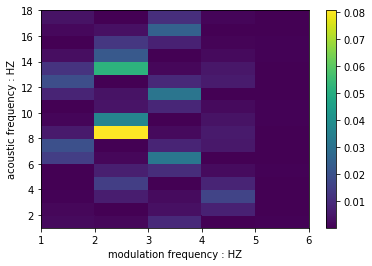

In [9]:
#s = E_re[:,:,2]
s = E_mean
x = np.linspace(1,18,18)
y = np.linspace(1,6,6)
T, F = np.meshgrid(x,y) 
#X_plot = 10 * np.log10(s[:,:].transpose() + np.finfo(float).eps) 
plt.pcolormesh(F, T, s)
#xtk = ['2','4','8','16','32','64',]
#ytk = ['10','100','300','700','1750','3900','7250']
#plt.xticks(y,xtk)
#plt.yticks(x,ytk)
plt.ylabel('acoustic frequency : HZ')
plt.xlabel('modulation frequency : HZ')
plt.colorbar()

Text(0.5, 0, 'modulation frequency : HZ')

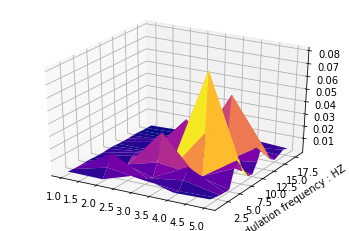

In [11]:
#s = E_re[:,:,1]
s = E_mean
from mpl_toolkits.mplot3d import Axes3D
x = np.linspace(1,18,18)
y = np.linspace(5,1,5)
T, F = np.meshgrid(x,y) 
fig = plt.figure()
ax = fig.gca(projection='3d') # 绘制成3D
ax.plot_surface(F,T,s,cmap='plasma')
#ax.plot_surface(T[None,:], F[:,None], 10*np.log10(Zxx), cmap='plasma')
#plt.xticks(y,xtk)
#plt.yticks(x,ytk)
plt.ylabel('acoustic frequency : HZ')
plt.ylabel('modulation frequency : HZ')

In [ ]:
plt.show()

In [ ]:
## testing stfft 
s = env
import scipy.signal as signal
winsec = 0.256 
win_shift = 0.04
nperseg = round(winsec * fs)
noverlap = round(win_shift/fs)
for ep in s:
    fs = sr
    f, t, Zxx = signal.stft(ep, fs,window='hamming',nperseg = nperseg,noverlap = noverlap)
    plt.pcolormesh(t, f, np.abs(Zxx))
    plt.ylim([0,32])
    #plt.title('STFT Magnitude')
    #plt.ylabel('Frequency [Hz]')
    #plt.xlabel('Time [sec]')
    plt.show()
    #plt.colorbar()

    #plt.pcolormesh(t, f, np.abs(Zxx), cmap=plt.get_cmap('plasma'))

In [ ]:
a

WARNING    C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1969: UserWarning: nperseg = 256 is greater than input length  = 97, using nperseg = 97
  .format(nperseg, input_length))
 [py.warnings]


the peak am and peak freq(hz) is 1.0261175257164787e-05 and 1.25


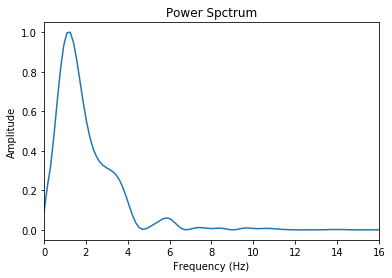

the peak am and peak freq(hz) is 1.53028044051732e-05 and 4.0625


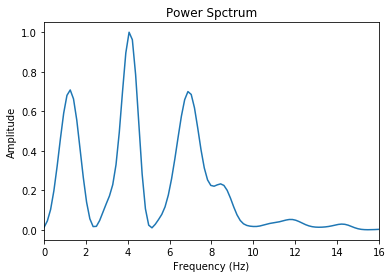

the peak am and peak freq(hz) is 0.00010257313454310656 and 0.9375


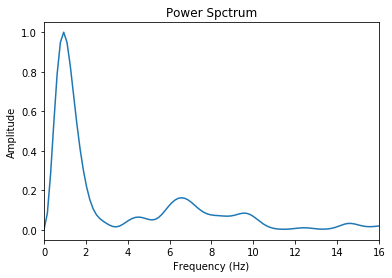

the peak am and peak freq(hz) is 4.290872805894894e-06 and 5.625


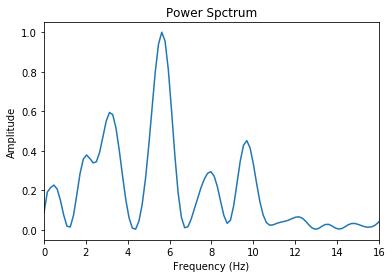

the peak am and peak freq(hz) is 1.0986578390486045e-05 and 3.90625


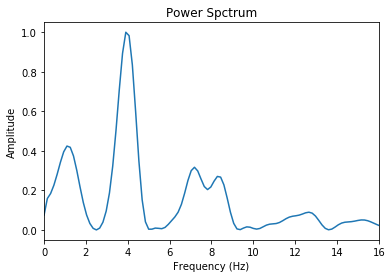

the peak am and peak freq(hz) is 9.060233923595478e-05 and 0.78125


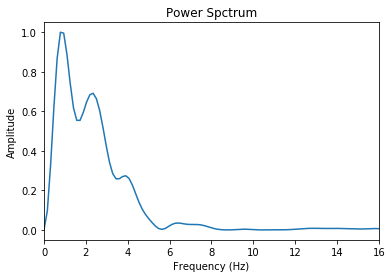

the peak am and peak freq(hz) is 4.653223100533075e-05 and 0.9375


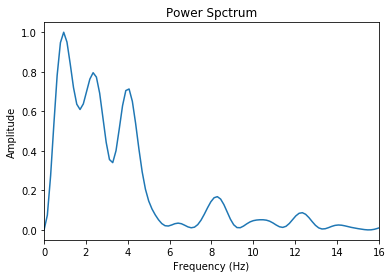

the peak am and peak freq(hz) is 1.0784065556353906e-05 and 4.53125


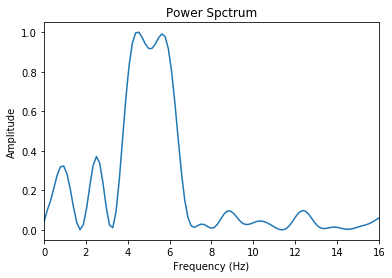

the peak am and peak freq(hz) is 3.8457377212867476e-05 and 5.625


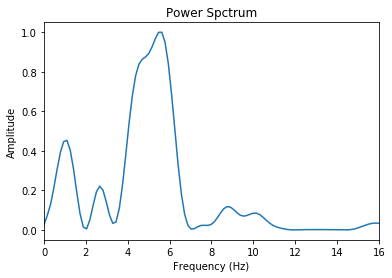

the peak am and peak freq(hz) is 4.7230028858826116e-05 and 5.625


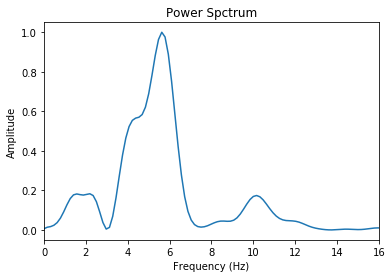

the peak am and peak freq(hz) is 3.045159995724028e-05 and 5.625


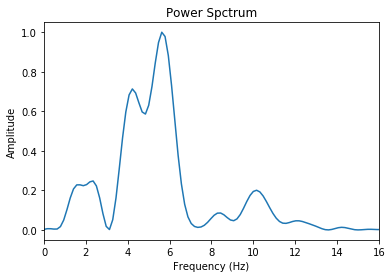

the peak am and peak freq(hz) is 2.0267101907310462e-05 and 5.625


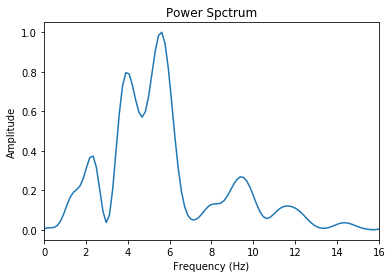

the peak am and peak freq(hz) is 6.204759285901162e-06 and 2.34375


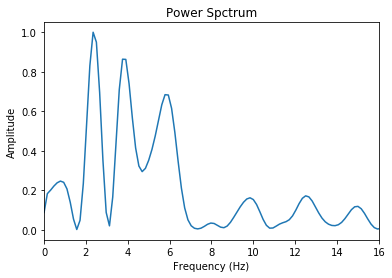

the peak am and peak freq(hz) is 6.5124116261681845e-06 and 2.34375


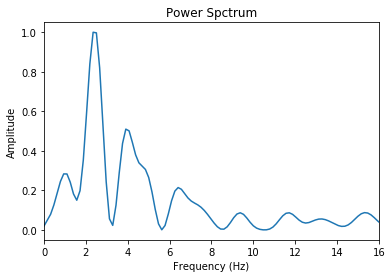

the peak am and peak freq(hz) is 1.8290353331022432e-06 and 2.34375


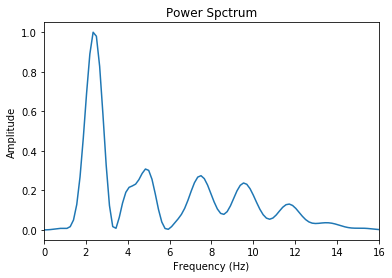

the peak am and peak freq(hz) is 5.241416038804961e-07 and 2.34375


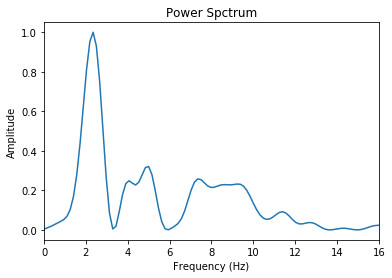

the peak am and peak freq(hz) is 7.346553000316253e-07 and 2.34375


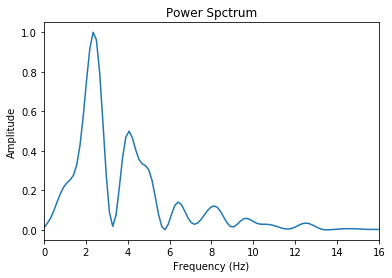

the peak am and peak freq(hz) is 5.173077495101236e-07 and 2.5


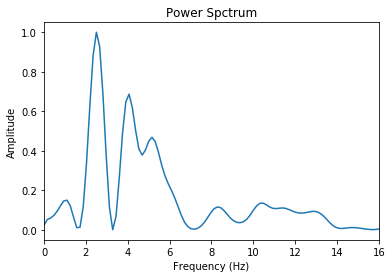

In [13]:
X_ma = []
for signal in af_s:
    analytic_signal = hilbert(signal)
    amplitude_envelope = np.abs(analytic_signal) 
    #b, a = butt_low(30, fs, order=4)
    #y = lfilter(b, a, amplitude_envelope)
    y = amplitude_envelope
    y_down = librosa.resample(y, sr, 80)
    y = y_down - np.mean(y_down)
    #plt.plot(y);plt.show()
    
    freqs,psd,bp = bandpower(y, 80, [3, 6])
    #print(freqs,psd)
    stats = dict(zip(freqs, psd))
    peak_amp = (max(psd))
    peak_freq = (max(stats, key=stats.get))
    print('the peak am and peak freq(hz) is {} and {}'.format(peak_amp,peak_freq))
#     X = scipy.fft(y)
#     X_mag = np.absolute(X)
#     X_ma.append(X_mag)
#     f = np.linspace(0, 80, len(X_mag)) # frequency variable
    X_ma.append(psd)
    plt.xlim([0, 16])
    plt.plot(freqs,psd/max(psd))# Frequency spectrum
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.title('Power Spctrum')
    plt.show()

#     plt.show()

In [14]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
from scipy.signal import butter, lfilter
import librosa, librosa.display
from scipy.signal import hilbert, chirp
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd

%matplotlib inline

x, sr = librosa.load('audio/rhythm_pattern_df/jp1.wav')
x, index = librosa.effects.trim(x,top_db= 20)


###

#parameter control  
###

def bandpower(data, sf, band, window_sec=None, relative=False):
    from scipy.signal import welch
    import scipy
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = scipy.signal.welch(data, sf,window = 'hamming',nfft = 512 ,scaling = 'density',average = 'mean')
#     if peak:
#         stats = dict(zip(freqs, psd))
#         peak_amp = (max(psd))
#         peak_freq = (max(stats, key=stats.get))
#         return peak_amp, peak_freq
    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)  # assignment operator shorthand for / and =
        
    return freqs, psd ,bp
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butt_low(lowcut, fs, order=5):
    nyq = 0.5 * sr
    low = lowcut / nyq
    b, a = butter(order, low, btype='low')
    return b, a


fs = sr
#frequency range
edges = [10,100,300,700,1750,3900,7250];       
lowcut = edges[:-1]
highcut = edges[1:]

af_s = []
env = []

for i in range(len(lowcut)): 
    plt.rcParams['figure.figsize'] = (16, 5)
    y = butter_bandpass_filter(x, lowcut[i], highcut[i], fs , order=2)
    af_s.append(y)
    print('band pass frequency range is {} - {}'.format(lowcut[i], highcut[i]))
    #analytic_signal = hilbert(y)
    #amplitude_envelope = np.abs(analytic_signal)
    
    amplitude_envelope = np.abs(y)
    b, a = butt_low(30, fs, order=4)
    z = lfilter(b, a, amplitude_envelope)
    env.append(z)
    #y_down = librosa.resample(z, sr, 80)
    #z = y_down - np.mean(y_down)
    #plt.plot(y);plt.show()
    #plt.plot(x,alpha=0.5);plt.plot(y,alpha=0.8);plt.plot(z,'c-.',linewidth=4, markersize=12);plt.show()
    #plt.plot(z,'b');plt.show()
    #plt.ylim(-0.10,0.20)


band pass frequency range is 10 - 100
band pass frequency range is 100 - 300
band pass frequency range is 300 - 700
band pass frequency range is 700 - 1750
band pass frequency range is 1750 - 3900
band pass frequency range is 3900 - 7250


In [ ]:
X_ma = []
for env in env:
    y_down = librosa.resample(env, sr, 80)
    y = y_down - np.mean(y_down)
    #plt.plot(y);plt.show()
    
    freqs,psd,bp = bandpower(y, 80, [3, 6])
    #print(freqs,psd)
    stats = dict(zip(freqs, psd))
    peak_amp = (max(psd))
    peak_freq = (max(stats, key=stats.get))
    print('the peak am and peak freq(hz) is {} and {}'.format(peak_amp,peak_freq))

#     X = scipy.fft(y)
#     X_mag = np.absolute(X)
#     X_ma.append(X_mag)
#     f = np.linspace(0, 80, len(X_mag)) # frequency variable
    X_ma.append(psd/max(psd))
    plt.xlim([0, 16])
    plt.plot(freqs,psd)# Frequency spectrum
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.title('Power Spctrum')
    plt.show()

(0, 16)

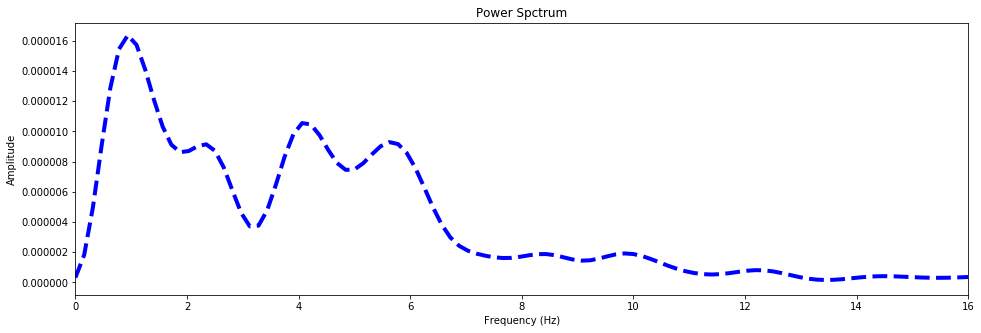

In [15]:
import statistics 
import numpy as np
#(np.array(X_ma[0]) + np.array(X_ma[1])) / 2.0
#x = np.mean(X_ma)ss = np.array(X_ma)
ss = np.array(X_ma)
s_mean = np.mean(ss,0)
#x = np.average(X_ma,axis=0)

s = np.mean(np.array([X_ma[i] ** 2 for i in range(len(X_ma))]), axis=0 ) ** 0.5
#x = statistics.mean(X_ma) 
plt.plot(freqs,s_mean,'b--',linewidth=4, markersize=12) ## freq 很关键
plt.rcParams['figure.figsize'] = (8, 5) 
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Power Spctrum')
#plt.xscale('log') 
plt.xlim([0, 16])
#t = [0.5,1,2,4,8,16]
#l = [0.5,1,2,4,8,16]
#plt.xticks(t,l)

In [ ]:
s = np.mean(np.array([X_ma[i] ** 2 for i in range(len(X_ma))]), axis=0 ) ** 0.5

In [ ]:
ss = np.array(X_ma)
s_mean = np.mean(ss,0)
s_mean.shape

In [ ]:
x = np.average(X_ma,axis=0)
s = np.mean(np.array([X_ma[i] ** 2 for i in range(len(X_ma))]), axis=0 ) ** 0.5
plt.plot(s_mean);plt.plot(s)